## 📚 Exercise 1
In this exercise, we will understand the functioning of TF/IDF ranking and implement and test a vector space retrieval model.

### Use case:
You are an engineer who is building a search engine for the recipe finder application _bestbakesinthebuilding.com_. In this application, users can search for their favorite recipe, ingredients, or any recipe-relevant term. The search engine should return relevant recipes that are stored in the website's DB. For the implementation of the searching functionality, you have to use the vector space retrieval model.

To build your system, you have available recipe data in the file bread.txt which is a dump from the application's DB.

The schema of the data is the following:

  DocID | Document Text
  ------|------------------
  1     | How to Bake Breads Without Baking Recipes
  2     | Smith Pies: Best Pies in London
  3     | Numerical Recipes: The Art of Scientific Computing
  4     | Breads, Pastries, Pies, and Cakes: Quantity Baking Recipes
  5     | Pastry: A Book of Best French Pastry Recipes


### Goal:
1. Preprocess the input text by tokenizing it and stemming it.
2. Vectorize the preprocessed text by implementing the TF/IDF function.
3. Test your method by searching for the query $Q = ``baking''$ and find the top-ranked documents according to the TF/IDF rank. 
4. Compare your implementation with the existing implementation of scikit-learn library.

### What are you learning in this exercise:
- Vector space retrieval model implementation.
- TF/IDF ranking.
- Evaluation of a text retrieval system.


In [1]:
# Loading of libraries and documents
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
from operator import itemgetter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\goali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\goali\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 1. Preprocess the input text by tokenizing it and stemming it.

In [2]:
stemmer = PorterStemmer() 
def tokenize(text):
    """
    It tokenizes and stems an input text.
    
    :param text: str, with the input text
    :return: list, of the tokenized and stemmed tokens.
    """
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return [stemmer.stem(word.lower()) for word in tokens if word not in stopwords.words('english')]

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", encoding="utf-8") as f:
    content = f.readlines()
original_documents = [x.strip() for x in content] 
documents = [tokenize(d) for d in original_documents]

documents

[['congrat',
  'ethen',
  '5th',
  'place',
  'epflen',
  '10th',
  'place',
  'httpstco8rlp0zzhyb'],
 ['if', 'that', 'stand', 'ovat', 'epflen', '🏆🙃😜👾🚀🎉', 'httpstco23kjig8pxt'],
 ['time',
  'open',
  'farm',
  'pitch',
  'openfood',
  'opendata',
  'epfl',
  'httpstco7lkkao5780'],
 ['good',
  'opportun',
  'ethen',
  'epflen',
  'epflpark',
  'uzhnewsen',
  'httpstcov3tojtyjqd'],
 ['excit',
  'news',
  'world',
  'univers',
  'rank',
  '20162017',
  'subject',
  'comput',
  'scienc',
  'no1',
  'eth',
  'amp',
  'epfl',
  'no8',
  'congrat',
  'httpstcoarslxzoshq'],
 ['epfl',
  'cryptotoken',
  'free',
  'energi',
  'httpstcovh9qgloqrr',
  'httpstco6utnj68psc',
  'httpstcogtxlhi6lt',
  'httpstcozyenraseir',
  'get',
  'rich'],
 ['scientist',
  'discov',
  'hidden',
  'pattern',
  'brain',
  'activ',
  'httpstcohblrytdmtt',
  'epfl'],
 ['edacyhq', 'with', 'edaci', 'invest', 'httpstcox2y212dkup'],
 ['deadlin',
  '19052017',
  'against',
  'breast',
  'cancer',
  'i',
  'research',
  'fun

#### 2. Vectorize the preprocessed text by implementing the TF/IDF function.

In [3]:
# Functions for the TF/IDF implementation

# create the vocabulary
vocabulary = list(set([item for sublist in documents for item in sublist]))
vocabulary.sort()

def idf_values(vocabulary, documents):
    """
    It computes IDF scores, storing idf values in a dictionary.
    
    :param vocabulary: list of str, with the unique tokens of the vocabulary.
    :param documents: list of lists of str, with tokenized sentences.
    :return: dict with the idf values for each vocabulary word.
    """
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf[term] = math.log(num_documents/sum([term in d for d in documents]), math.e)
    return idf


def vectorize(document, vocabulary, idf):
    """
    It generates the vector for an input document (with normalization).
    
    :param document: list of str with the tokenized documents.
    :param vocabulary: list of str, with the unique tokens of the vocabulary.
    :param idf: dict with the idf values for each vocabulary word.
    :return: list of floats
    """
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] =  idf[term] * counts[term]/max_count
    return vector

# Compute IDF values and vectors
idf = idf_values(vocabulary, documents)
document_vectors = [vectorize(s, vocabulary, idf) for s in documents]

def cosine_similarity(v1,v2):
    """
    It computes cosine similarity.
    
    :param v1: list of floats, with the vector of a document.
    :param v2: list of floats, with the vector of a document.
    :return: float
    """
    
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/math.sqrt(sumxx*sumyy)
    return result

def search_vec(query, topk=10):
    q = query.split()
    q = [stemmer.stem(w) for w in q]
    query_vector = vectorize(q, vocabulary, idf)
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    for i in range(topk):
        doc_ids.append(scores[i][1])
    return doc_ids
# HINTS
# natural logarithm function
#     math.log(n,math.e)
# Function to count term frequencies in a document
#     Counter(document)
# most common elements for a list
#     counts.most_common(1)

#### 3. Test your method by searching for the query  𝑄=‘‘𝑏𝑎𝑘𝑖𝑛𝑔″  and find the top-ranked documents according to the TF/IDF rank.

In [4]:
# Reference code using scikit-learn
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()
new_features = tf.transform(['baking'])

cosine_similarities = linear_kernel(new_features, features).flatten()
related_docs_indices = cosine_similarities.argsort()[::-1]
topk = 5
for i in range(topk):
    print(original_documents[related_docs_indices[i]])

@Repub_News @EPFL_en you are in Russian media =)
Human genomics of infection and immunity, working closely with engineering and clinical colleagues @EPFL @CHUVLausanne. Please get in touch!
L'app pour «liker» en direct les transports publics https://t.co/3HbkTnIE3Q #epfl
Dr. Julien Faget from @epflSV @EPFL_en will talk about flow cytometry unsupervised analyses: from immune signature to functional biology https://t.co/tAQF8VOLQS
The Swiss Team has won the Solar Decathlon competition  via @EPFL_en / Congrats! @Swiss_Living #VDtech https://t.co/dY437yk4su


#### 4.Compare your implementation with the existing implementation of scikit-learn library.

In this part, we consider the scikit reference code as an “oracle” that supposedly gives the correct result. Your task is to compare your implemented tf-idf retrieval model with this oracle for the following queries "computer science", "IC school", "information systems" on the **epfldocs.txt** collection.

For this exercise, you need to replace **bread.txt** in the first cell with **epfldocs.txt** and rerun all the cells from the begining. 

In [5]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

def search_vec_sklearn(query, features, threshold=0.1):
    """
    Return all document ids that that have cosine similarity with the query larger than a threshold.
    
    :param query: str
    :param features: ndarray
    :param threshold: float
    :return: list of int
    """
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

In [6]:
ret_ids = search_vec_sklearn('computer science', features)
for i, v in enumerate(ret_ids):
    print(original_documents[v])

Exciting News: "World University Rankings 2016-2017 by subject: computer science" No1 @ETH &amp; @EPFL on No8. Congrats https://t.co/ARSlXZoShQ
New computer model shows how proteins are controlled "at a distance" https://t.co/zNjK3bZ6mO  via @EPFL_en #VDtech https://t.co/b9TglXO4KD
An interview with Patrick Barth, a new @EPFL professor who combines protein #biophysics with computer modeling https://t.co/iJwBaEbocj
Exposure Science Film Hackathon 2017 applications open! Come join our Scicomm-film-hacking event! #Science #scicomm https://t.co/zwtKPlh6HT
Le mystère Soulages éblouit la science @EPFL  https://t.co/u3uNICyAdi
@cwarwarrior @EPFL_en @EPFL Doing science at @EPFL_en is indeed pretty cool!!! Thank you for visiting!!!
Blue Brain Nexus: an open-source tool for data-driven science https://t.co/m5yTgXf7ym #epfl
Swiss Data Science on Twitter: "Sign up for @EPFL_en #DataJamDays: learn more a… https://t.co/kNVILHWPGb, see more https://t.co/2wg3BbHBNq
The registration for Exposure Scienc

In [7]:
queries = ["computer science", "IC school", "information systems"]

In [8]:
def compute_recall_at_k(predict, gt, k):
    """
    It computes the recall score at a defined set of retrieved documents.
    
    :param predict: list of predictions
    :param gt: list of actual data
    :param k: int
    """
    # Recall = tp / (tp + fn)
    tp = 0
    fn = 0
    prediction = predict[:k]
    
    for i in range(len(prediction)):
        if prediction[i] in gt:
            tp += 1
    
    for item in gt:
        if item not in prediction:
            fn += 1
    
    return tp / (tp + fn) if (tp + fn) > 0 else 0
    

In [9]:
def compute_precision_at_k(predict, gt, k):
    """
    It computes the precision score at a defined set of retrieved documents.
    
    :param predict: list of predictions
    :param gt: list of actual data
    :param k: int
    """
    # Precision = tp / (tp + fp)
    tp = 0
    fp = 0
    prediction = predict[:k]
    
    # Calculate true positives and false positives
    for i in range(len(prediction)):
        if prediction[i] in gt:
            tp += 1
        else:
            fp += 1
    
    return tp / (tp + fp) if (tp + fp) > 0 else 0

In [34]:
def compute_interpolated_precisions(precision, recall):
    max_prec = []
    current_max_precision = []
    for k in range(0, len(recall)):
        # For recall[k] check which max value for precision[k:end]
        current_recall = recall[k]
        max_prec.append(max(precision[k:]))
    return max_prec
    

In [105]:
def compute_map(queries, K = 20):
    """
    It computes mean average precision (MAP) for a set of queries.
    
    :param queries: list of str
    :param K: int
    """
    map_score = 0
    for i, query in enumerate(queries):
        precision_for_query = 0
        recall_for_query = 0
        prec_recall = []
        precision = []
        recall = []
        predict = search_vec(query, K)
        gt = search_vec_sklearn(query, features)
        for k in range(1, K+1):
            precision_for_query = compute_precision_at_k(predict, gt, k)
            recall_for_query = compute_recall_at_k(predict, gt, k)
            # Calculate the Precision interpolated
            precision.append(precision_for_query)
            recall.append(recall_for_query)

        prec_interpo = compute_interpolated_precisions(precision, recall)

        # Calculate only for the relevant values
        p_int_relevant = sum(prec_interpo[i] for i, retrieved in enumerate(predict) if retrieved in gt)
        
        map_score += p_int_relevant/len(gt)
    map_score = 1/len(queries) * map_score
    return map_score, prec_interpo, precision, recall

In [106]:
map_score, prec_interpo, precision, recall = compute_map(queries)

In [107]:
print(map_score)

0.6030573416951126


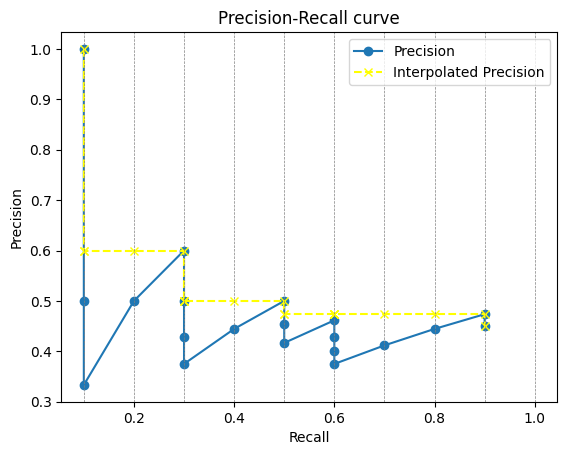

In [108]:
# Plot the prec-recall curve for interpolated precision (according to the previous function)
import matplotlib.pyplot as plt

def plot_prec_recall_curve(precision, recall, prec_interpo):
    plt.plot(recall, precision, marker='o', label='Precision')
    plt.plot(recall, prec_interpo, marker='x', linestyle='--', color='yellow', label='Interpolated Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    # Add vertical lines at every 0.1 on the recall axis up to 0.5
    for r in range(1, 11):
        plt.axvline(x=r/10, color='gray', linestyle='--', linewidth=0.5)
    
    plt.legend()
    plt.show()

plot_prec_recall_curve(precision, recall, prec_interpo)
